# NLP CLASSIFICATION MODEL
### TRAIN MODEL TO PREDICT PROBABILITY OF POSITIVE/NEGATIVE TWEET BASED ON LOCATION

# Step 0:
### Importing libraries and data:

In [13]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Use dataframe with tweets that have gone through pre-processing for NLP, and which are already tagged after TextBlob sentiment_object:

tweets_analysis = pd.read_csv('tweets_analysis.csv')
tweets_analysis.drop('Unnamed: 0', axis=1, inplace=True)
tweets_analysis.head()

,TweetText,Handle,Location,Country,Language,text_processed,Polarity,Subjectivity,Sentiment
0,RT @rachel_groves: Daily goals: Wake up early....,joscchh,"Bonn, Deutschland",Germany,en,"['daili', 'goal', 'wake', 'earli', 'drink', 'c...",0.194048,0.427381,positive
1,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,"Bonn, Deutschland",Germany,en,"['good', 'topic', 'well', 'done']",0.700000,0.600000,positive
2,@jpbrice Life is always precious - every singl...,joscchh,"Bonn, Deutschland",Germany,en,"['jpbrice', 'life', 'alway', 'precious', 'ever...",0.272381,0.609524,positive
3,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,"Bonn, Deutschland",Germany,en,"['petershepherd', 'myork', 'zereadyoregon', 'g...",0.200000,0.385417,positive
4,RT @jpbrice: “You never know how strong you ar...,joscchh,"Bonn, Deutschland",Germany,en,"['never', 'know', 'strong', 'strong', 'onli', ...",0.288889,0.822222,positive


In [63]:
type(tweets_analysis['text_processed'][0])

# SHOULD BE a list. Thats how it was exported after NLP-pre-processing steps. 

str

In [48]:
tweets_analysis['text_processed']
# can I just use regex to remove the '' around each token?? Or will that not be enough

0       ['daili', 'goal', 'wake', 'earli', 'drink', 'c...
1                       ['good', 'topic', 'well', 'done']
2       ['jpbrice', 'life', 'alway', 'precious', 'ever...
3       ['petershepherd', 'myork', 'zereadyoregon', 'g...
4       ['never', 'know', 'strong', 'strong', 'onli', ...
                              ...                        
7854    ['friedrich', 'merz', 'frau', 'geheiratet', 'm...
7855    ['hatt', 'nie', 'gedacht', 'mal', 'sag', 'druc...
7856    ['echt', 'frau', 'job', 'abgibt', 'au', 'grund...
7857    ['perfid', 'begriff', 'neidsteu', 'uberhaupt',...
7858    ['gerad', 'foto', 'gepostet', 'berlin', 'germa...
Name: text_processed, Length: 7859, dtype: object

In [67]:
test = tweets_analysis['text_processed'][0]
type(test)      

str

# Step 1:
### DF processed text format got messed up in import/export. Re-do preprocessing steps before training model.

In [80]:
tweets_analysis['text'] = tweets_analysis['TweetText']

def clean_up(x):
    """ Clean up the text before NLP. 
    Remove Punctuation, remove retweet and @.
    Keep German characters as vowels."""
    
    remove_rt = lambda x: re.sub('RT @\w+: ', "", x)
    lab = lambda x: re.sub('[^äöüÄÖÜA-Za-z ]+','', x)
    tw_1 = remove_rt(x)
    tw_2 = lab(tw_1)
    tw_3 =  tw_2.lower()
    
    return tw_3


tweets_analysis['text'] = tweets_analysis['text'].apply(clean_up)

In [83]:
def tokenize(x):
    """Tokenize the tweets."""
    
    from nltk.tokenize import word_tokenize
    tokenized_x = word_tokenize(x)
    return tokenized_x


tweets_analysis['tokenized_tw'] = tweets_analysis['text'].apply(tokenize)
# tweets_analysis.head()

In [98]:
tweets_en = tweets_analysis[tweets_analysis['Language']=='en']
tweets_de = tweets_analysis[tweets_analysis['Language']=='de']

In [99]:
def stem_lemmatize_en(l):
    """This function performs both stemming and lemmatization on our english tweets."""
    
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    l = [lemmatizer.lemmatize(item) for item in l]
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("english")
    l = [stemmer.stem(item) for item in l]
    
    return l 


tweets_en['stem_lemm_tw'] = tweets_en['tokenized_tw'].apply(stem_lemmatize_en)

In [100]:
def stem_lemmatize_de(l):
    """This function performs both stemming and lemmatization on our german tweets."""
    
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    l = [lemmatizer.lemmatize(item) for item in l]
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("german")
    l = [stemmer.stem(item) for item in l]
    
    return l 

tweets_de['stem_lemm_tw'] = tweets_de['tokenized_tw'].apply(stem_lemmatize_de)

In [101]:
def remove_stopwords_en(l):
    """Remove english stopwords from a list of tweets."""
    
    from nltk.corpus import stopwords
    stopwords_list = stopwords.words("english")
    l = [item for item in l if not item in stopwords_list]
    
    return l

tweets_en['remove_stopwords_tw'] = tweets_en['stem_lemm_tw'].apply(remove_stopwords_en)

In [102]:
def remove_stopwords_de(l):
    """Remove german stopwords from a list of tweets."""
    
    from nltk.corpus import stopwords
    stopwords_list = stopwords.words("german")
    l = [item for item in l if not item in stopwords_list]
    
    return l

tweets_de['remove_stopwords_tw'] = tweets_de['stem_lemm_tw'].apply(remove_stopwords_de)

In [103]:
tweets_en.head()

,TweetText,Handle,Location,Country,Language,text_processed,Polarity,Subjectivity,Sentiment,text,tokenized_tw,stem_lemm_tw,remove_stopwords_tw
0,RT @rachel_groves: Daily goals: Wake up early....,joscchh,"Bonn, Deutschland",Germany,en,"['daili', 'goal', 'wake', 'earli', 'drink', 'c...",0.194048,0.427381,positive,daily goals wake up early drink coffee work ha...,"[daily, goals, wake, up, early, drink, coffee,...","[daili, goal, wake, up, earli, drink, coffe, w...","[daili, goal, wake, earli, drink, coffe, work,..."
1,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,"Bonn, Deutschland",Germany,en,"['good', 'topic', 'well', 'done']",0.700000,0.600000,positive,good topic well done,"[good, topic, well, done]","[good, topic, well, done]","[good, topic, well, done]"
2,@jpbrice Life is always precious - every singl...,joscchh,"Bonn, Deutschland",Germany,en,"['jpbrice', 'life', 'alway', 'precious', 'ever...",0.272381,0.609524,positive,jpbrice life is always precious every single ...,"[jpbrice, life, is, always, precious, every, s...","[jpbrice, life, is, alway, precious, everi, si...","[jpbrice, life, alway, precious, everi, singl,..."
3,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,"Bonn, Deutschland",Germany,en,"['petershepherd', 'myork', 'zereadyoregon', 'g...",0.200000,0.385417,positive,petershepherd myorke zereadyoregon great we h...,"[petershepherd, myorke, zereadyoregon, great, ...","[petershepherd, myork, zereadyoregon, great, w...","[petershepherd, myork, zereadyoregon, great, l..."
4,RT @jpbrice: “You never know how strong you ar...,joscchh,"Bonn, Deutschland",Germany,en,"['never', 'know', 'strong', 'strong', 'onli', ...",0.288889,0.822222,positive,you never know how strong you are until being ...,"[you, never, know, how, strong, you, are, unti...","[you, never, know, how, strong, you, are, unti...","[never, know, strong, strong, onli, choic, quo..."


In [104]:
# tweets_en.drop(['tokenized_tw', 'stem_lemm_tw', 'text', 'UserDescription', 'CreatedAt', 'ID', 'Follower'], axis=1, inplace=True)
tweets_en.rename(columns={'remove_stopwords_tw': 'Text_processed'}, inplace=True)
tweets_en.head()

,TweetText,Handle,Location,Country,Language,text_processed,Polarity,Subjectivity,Sentiment,text,tokenized_tw,stem_lemm_tw,Text_processed
0,RT @rachel_groves: Daily goals: Wake up early....,joscchh,"Bonn, Deutschland",Germany,en,"['daili', 'goal', 'wake', 'earli', 'drink', 'c...",0.194048,0.427381,positive,daily goals wake up early drink coffee work ha...,"[daily, goals, wake, up, early, drink, coffee,...","[daili, goal, wake, up, earli, drink, coffe, w...","[daili, goal, wake, earli, drink, coffe, work,..."
1,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,"Bonn, Deutschland",Germany,en,"['good', 'topic', 'well', 'done']",0.700000,0.600000,positive,good topic well done,"[good, topic, well, done]","[good, topic, well, done]","[good, topic, well, done]"
2,@jpbrice Life is always precious - every singl...,joscchh,"Bonn, Deutschland",Germany,en,"['jpbrice', 'life', 'alway', 'precious', 'ever...",0.272381,0.609524,positive,jpbrice life is always precious every single ...,"[jpbrice, life, is, always, precious, every, s...","[jpbrice, life, is, alway, precious, everi, si...","[jpbrice, life, alway, precious, everi, singl,..."
3,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,"Bonn, Deutschland",Germany,en,"['petershepherd', 'myork', 'zereadyoregon', 'g...",0.200000,0.385417,positive,petershepherd myorke zereadyoregon great we h...,"[petershepherd, myorke, zereadyoregon, great, ...","[petershepherd, myork, zereadyoregon, great, w...","[petershepherd, myork, zereadyoregon, great, l..."
4,RT @jpbrice: “You never know how strong you ar...,joscchh,"Bonn, Deutschland",Germany,en,"['never', 'know', 'strong', 'strong', 'onli', ...",0.288889,0.822222,positive,you never know how strong you are until being ...,"[you, never, know, how, strong, you, are, unti...","[you, never, know, how, strong, you, are, unti...","[never, know, strong, strong, onli, choic, quo..."


In [105]:
tweets_de.rename(columns={'remove_stopwords_tw': 'Text_processed'}, inplace=True)
tweets_de.head()

,TweetText,Handle,Location,Country,Language,text_processed,Polarity,Subjectivity,Sentiment,text,tokenized_tw,stem_lemm_tw,Text_processed
4789,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,"Bonn, Deutschland",Germany,de,"['snvberlin', 'expertinnenworkshop', 'staatlic...",-0.350000,0.00,negative,unser snvberlin expertinnenworkshop zur staatl...,"[unser, snvberlin, expertinnenworkshop, zur, s...","[uns, snvberlin, expertinnenworkshop, zur, sta...","[snvberlin, expertinnenworkshop, staatlich, be..."
4790,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,"Bonn, Deutschland",Germany,de,"['fing', 'gut', 'bonn', 'braucht', 'mindshift'...",0.250000,0.25,positive,fing gut an bonn braucht einen mindshift von d...,"[fing, gut, an, bonn, braucht, einen, mindshif...","[fing, gut, an, bonn, braucht, ein, mindshift,...","[fing, gut, bonn, braucht, mindshift, autostad..."
4791,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,"Bonn, Deutschland",Germany,de,"['gest', 'lichtemoment', 'askan', 'michaeladl'...",0.000000,0.00,neutral,gestern haben lichtemomente askans michaeladle...,"[gestern, haben, lichtemomente, askans, michae...","[gest, hab, lichtemoment, askan, michaeladl, b...","[gest, lichtemoment, askan, michaeladl, barbar..."
4792,@VolkerGoebbels Macht Sinn 😏,joscchh,"Bonn, Deutschland",Germany,de,"['volkergoebbel', 'macht', 'sinn']",0.000000,0.00,neutral,volkergoebbels macht sinn,"[volkergoebbels, macht, sinn]","[volkergoebbel, macht, sinn]","[volkergoebbel, macht, sinn]"
4793,@jbrunotte Was waren denn deine Beweggründe da...,joscchh,"Bonn, Deutschland",Germany,de,"['jbrunott', 'wa', 'beweggrund', 'dafur', 'spa...",0.233333,0.00,positive,jbrunotte was waren denn deine beweggründe daf...,"[jbrunotte, was, waren, denn, deine, beweggrün...","[jbrunott, wa, war, denn, dein, beweggrund, da...","[jbrunott, wa, beweggrund, dafur, spannend, wiss]"


In [106]:
tweets_en.drop('text_processed', axis=1, inplace=True)
tweets_de.drop('text_processed', axis=1, inplace=True)

In [110]:
tweets_analysis_new = pd.concat([tweets_en, tweets_de], ignore_index=True)
tweets_analysis_new.head()

,TweetText,Handle,Location,Country,Language,Polarity,Subjectivity,Sentiment,text,tokenized_tw,stem_lemm_tw,Text_processed
0,RT @rachel_groves: Daily goals: Wake up early....,joscchh,"Bonn, Deutschland",Germany,en,0.194048,0.427381,positive,daily goals wake up early drink coffee work ha...,"[daily, goals, wake, up, early, drink, coffee,...","[daili, goal, wake, up, earli, drink, coffe, w...","[daili, goal, wake, earli, drink, coffe, work,..."
1,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,"Bonn, Deutschland",Germany,en,0.700000,0.600000,positive,good topic well done,"[good, topic, well, done]","[good, topic, well, done]","[good, topic, well, done]"
2,@jpbrice Life is always precious - every singl...,joscchh,"Bonn, Deutschland",Germany,en,0.272381,0.609524,positive,jpbrice life is always precious every single ...,"[jpbrice, life, is, always, precious, every, s...","[jpbrice, life, is, alway, precious, everi, si...","[jpbrice, life, alway, precious, everi, singl,..."
3,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,"Bonn, Deutschland",Germany,en,0.200000,0.385417,positive,petershepherd myorke zereadyoregon great we h...,"[petershepherd, myorke, zereadyoregon, great, ...","[petershepherd, myork, zereadyoregon, great, w...","[petershepherd, myork, zereadyoregon, great, l..."
4,RT @jpbrice: “You never know how strong you ar...,joscchh,"Bonn, Deutschland",Germany,en,0.288889,0.822222,positive,you never know how strong you are until being ...,"[you, never, know, how, strong, you, are, unti...","[you, never, know, how, strong, you, are, unti...","[never, know, strong, strong, onli, choic, quo..."


# Step 1:
### Prepare the data for continued analysis:

In [111]:
# drop neutral tweets? How many are left?
tweets_analysis_new['Sentiment'].value_counts()
tweets = tweets_analysis_new[tweets_analysis_new['Sentiment']!='neutral']
tweets['Sentiment'].value_counts()

# consider saving this df (excludes neutral tweets) for visualizations in other notebook!

positive    3043
negative     843
Name: Sentiment, dtype: int64

In [112]:
# Add ['target'] column with 0 if negative, 1 is positive

tweets['target'] = np.where((tweets['Sentiment']=='negative'), 0, 1)
tweets.head()

,TweetText,Handle,Location,Country,Language,Polarity,Subjectivity,Sentiment,text,tokenized_tw,stem_lemm_tw,Text_processed,target
0,RT @rachel_groves: Daily goals: Wake up early....,joscchh,"Bonn, Deutschland",Germany,en,0.194048,0.427381,positive,daily goals wake up early drink coffee work ha...,"[daily, goals, wake, up, early, drink, coffee,...","[daili, goal, wake, up, earli, drink, coffe, w...","[daili, goal, wake, earli, drink, coffe, work,...",1
1,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,"Bonn, Deutschland",Germany,en,0.700000,0.600000,positive,good topic well done,"[good, topic, well, done]","[good, topic, well, done]","[good, topic, well, done]",1
2,@jpbrice Life is always precious - every singl...,joscchh,"Bonn, Deutschland",Germany,en,0.272381,0.609524,positive,jpbrice life is always precious every single ...,"[jpbrice, life, is, always, precious, every, s...","[jpbrice, life, is, alway, precious, everi, si...","[jpbrice, life, alway, precious, everi, singl,...",1
3,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,"Bonn, Deutschland",Germany,en,0.200000,0.385417,positive,petershepherd myorke zereadyoregon great we h...,"[petershepherd, myorke, zereadyoregon, great, ...","[petershepherd, myork, zereadyoregon, great, w...","[petershepherd, myork, zereadyoregon, great, l...",1
4,RT @jpbrice: “You never know how strong you ar...,joscchh,"Bonn, Deutschland",Germany,en,0.288889,0.822222,positive,you never know how strong you are until being ...,"[you, never, know, how, strong, you, are, unti...","[you, never, know, how, strong, you, are, unti...","[never, know, strong, strong, onli, choic, quo...",1


In [113]:
tweets['target'].value_counts()

1    3043
0     843
Name: target, dtype: int64

### Vectorizing Text:

In [114]:
# from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x: x) # adding this argument here will allow you to apply it to the entire df in the next step

In [130]:
X = vectorizer.fit_transform(tweets['Text_processed']).toarray()

In [131]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Step 2:
### Split into train and test set:

In [117]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, tweets['target'], test_size=0.33, random_state=123)

In [118]:
# from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [119]:
# predict whether the tweet is positive
predictions = clf.predict(X_test)
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [120]:
clf.score(X_test, y_test)

0.8347622759158223

In [121]:
print("Precision score: ", precision_score(y_test, predictions))
print("Recall score: ", recall_score(y_test, predictions))
print("F1 score: ", f1_score(y_test, predictions))

Precision score:  0.8351464435146444
Recall score:  0.9851924975320829
F1 score:  0.9039855072463769


In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

[[ 73 197]
 [ 15 998]]


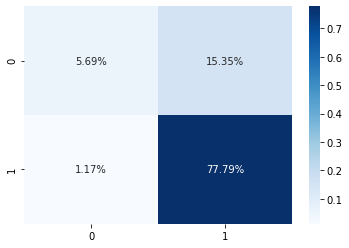

In [123]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,
           fmt='.2%', cmap='Blues')

# This cant be right... the true predictions should fall along the diagonal axis. 

# Step 3:
### Predict probability of positive tweet by `['Country']`:

In [126]:
clf.predict_proba?